# **Import**

In [12]:
import os, sys
sys.path.append('../')
os.chdir('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import random
import numpy as np
import pandas as pd

from transformers import BertTokenizer, BertConfig, BertForPreTraining, BertForSequenceClassification
from nltk.tokenize import TweetTokenizer, word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from nltk.corpus import stopwords
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
!pip install pysastrawi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Data Load**

In [52]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## **Load Dataset**

In [15]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving spam.csv to spam.csv


In [30]:
df = pd.read_csv('spam.csv')
df.head()


,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [32]:
df['label'].value_counts()

label
1    574
0    569
Name: count, dtype: int64

In [33]:
df.isnull().sum()

Teks     0
label    0
dtype: int64

In [34]:
duplicates = df[df.duplicated(keep=False)]
print("Duplicate Rows:\n", duplicates)

Duplicate Rows:
                                                   Teks  label
658  bebas nama1, terus nanti kalau ada tgl libur, ...      0
679  bebas nama1, terus nanti kalau ada tgl libur, ...      0


In [35]:
df_cleaned = df.drop_duplicates()

# Display the number of duplicates removed
print(f"Number of duplicates removed: {df.duplicated().sum()}")
print("Cleaned DataFrame:\n", df_cleaned.head())

Number of duplicates removed: 1
Cleaned DataFrame:
                                                 Teks  label
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...      1
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...      1
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...      1
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...      1
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...      1


In [36]:
df.shape

(1143, 2)

In [37]:
df2 = df.copy()

In [38]:
df2['sentiment'] = df2['label'].replace({ 0: 'Bukan Spam',  1: 'Spam'})
df2

,Teks,label,sentiment
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,Spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,Spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,Spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,Spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,Spam
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,Bukan Spam
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,Bukan Spam
1140,Mba mau kirim 300 ya,0,Bukan Spam
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,Bukan Spam


# **Text Processing**

In [39]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [40]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('english')))
stpwds_id.append('oh') # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

In [41]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [42]:
df

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0
1140,Mba mau kirim 300 ya,0
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0


In [43]:
# Applying Text Preprocessing to the Dataset
df['text_processed'] = df['Teks'].apply(lambda x: text_preprocessing(x))
df

,Teks,label,text_processed
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,promo beli paket flash mulai gb di telkomsel a...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,gb hari hanya rp ribu spesial buat anda yang p...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,plg yth sisa kuota flash anda kb download myte...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,plg yth sisa kuota flash anda kb download myte...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,gb hari hanya rp ribu spesial buat anda yang p...
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo sama oke nanti aku umumin di grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,belum ga ad nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mba mau kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagi mau cas atay tranfer


In [44]:
df2 = df2.rename(columns={'text_processed': 'text_processed', 'label':'label'})
df2['label'] = df2['label'].map({0: 0.0, 1: 1.0, 2:2.0})
# # Output first five rows
df2.head()

,Teks,label,sentiment
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1.0,Spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1.0,Spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1.0,Spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1.0,Spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1.0,Spam


# **Exploratory Data Analysis**

<Axes: xlabel='label'>

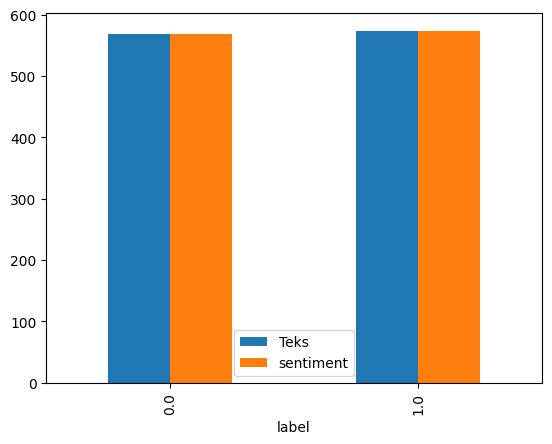

In [45]:
df2.groupby('label').count().plot(kind='bar')

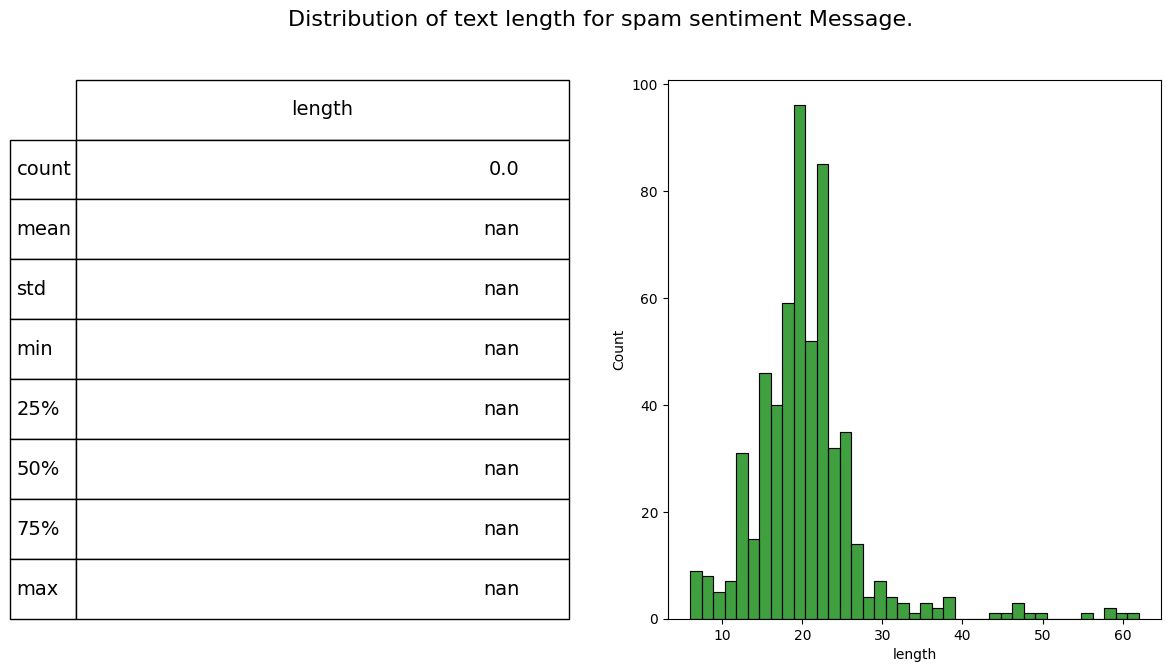

In [47]:
fig = plt.figure(figsize=(14,7))
df2['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df2[df2['sentiment']=='Spam']['length'], ax=ax1,color='green')
describe = df2.length[df2.sentiment=='spam'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for spam sentiment Message.', fontsize=16)

plt.show()

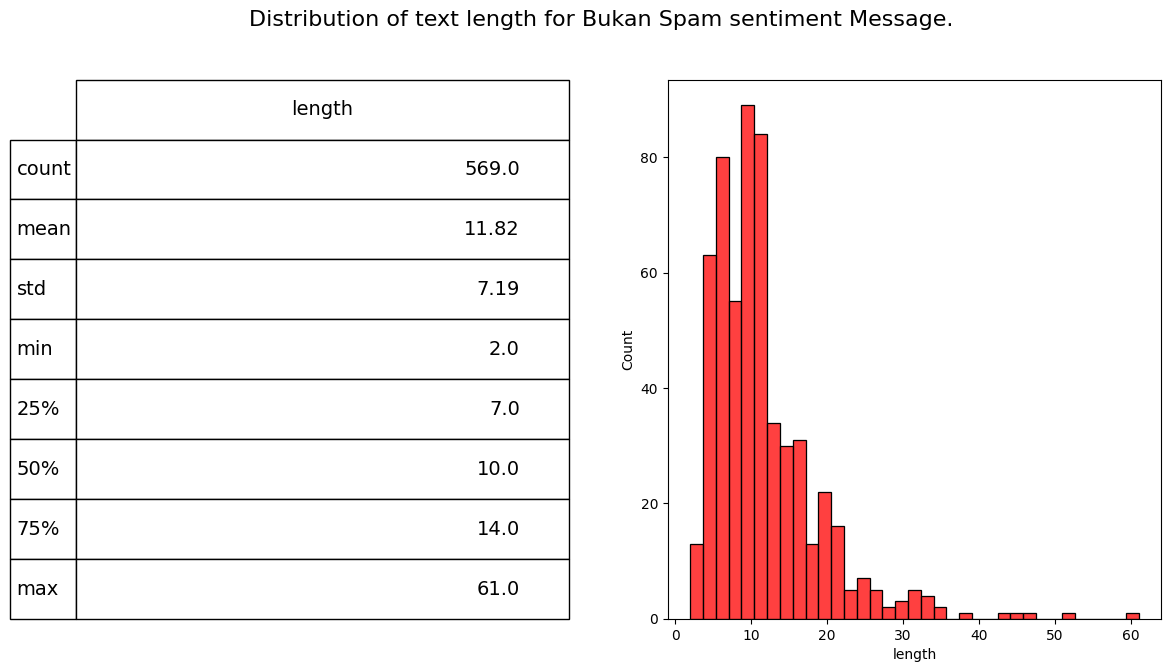

In [48]:
fig = plt.figure(figsize=(14,7))
df2['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df2[df2['sentiment']=='Bukan Spam']['length'], ax=ax1,color='red')
describe = df2.length[df2.sentiment=='Bukan Spam'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Bukan Spam sentiment Message.', fontsize=16)

plt.show()

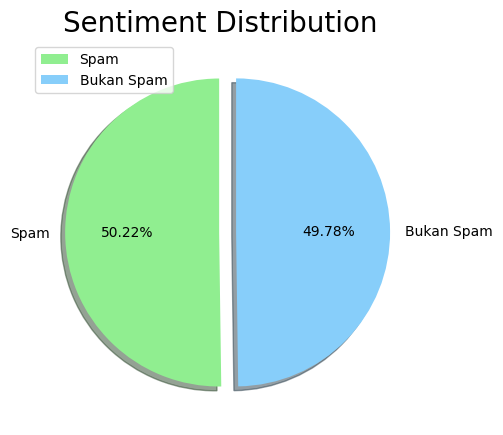

In [49]:
labels = ['Spam', 'Bukan Spam']
size = df2['sentiment'].value_counts()
colors = ['lightgreen', 'lightskyblue']
explode = [0.01, 0.1]

fig, axes = plt.subplots(figsize=(6, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Sentiment Distribution', fontsize = 20)
plt.legend()
plt.show()

# **Data Spliting**

In [50]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_processed,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  )

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (873,)
Val Size   :  (98,)
Test Size  :  (172,)


# **Create a custom dataset class for your data**

In [56]:

class SpamDataset:
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='np'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

# **Create data generators for training, validation, and testing**